In [55]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from wordcloud import WordCloud 
from nltk.corpus import stopwords 
import nltk


In [13]:
input_filename = "datos_finales_para_ml_rev2.csv"
try:
    datos_combinados = pd.read_csv(input_filename)
    print("Datos cargados")
except Exception as e:
    print("Error al cargar")

Datos cargados


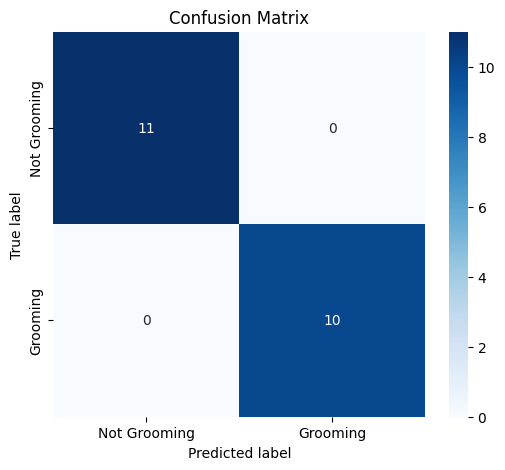


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [58]:
X = datos_combinados['full_chat']
y = datos_combinados['label']

vectorizer = TfidfVectorizer(max_features=10000, stop_words = 'english', sublinear_tf=True)
X_tfidf = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y , test_size=0.2, random_state=42, stratify=y)

model = LogisticRegression (max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(figsize=(6, 5))
# Dibujamos el heatmap de la matriz de confusión
sns.heatmap(
    cm,                    # Matriz de confusión
    annot=True,                # Muestra los números dentro de cada celda
    fmt="d",                   # Formato entero
    cmap="Blues",              # Colormap azul
    xticklabels=['Not Grooming', 'Grooming'],
    yticklabels=['Not Grooming', 'Grooming'],
    ax=axes
)

axes.set_title("Confusion Matrix")
axes.set_xlabel("Predicted label")
axes.set_ylabel("True label")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [52]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_tfidf, y, cv=skf, scoring='f1')

print("F1 scores:", scores)
print("Mean F1:", scores.mean())

F1 scores: [1. 1. 1. 1. 1.]
Mean F1: 1.0


Por lo que podemos ver que en efecto estamos teniendo overfitting, 

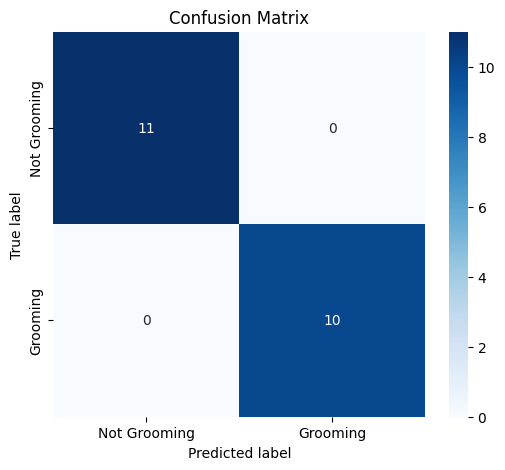


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [62]:
model2 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

model2.fit(X_train, y_train)

y_pred2 = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred2)

fig, axes = plt.subplots(figsize=(6, 5))
# Dibujamos el heatmap de la matriz de confusión
sns.heatmap(
    cm,                    # Matriz de confusión
    annot=True,                # Muestra los números dentro de cada celda
    fmt="d",                   # Formato entero
    cmap="Blues",              # Colormap azul
    xticklabels=['Not Grooming', 'Grooming'],
    yticklabels=['Not Grooming', 'Grooming'],
    ax=axes
)

axes.set_title("Confusion Matrix")
axes.set_xlabel("Predicted label")
axes.set_ylabel("True label")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Revisaremos que palabras son mas importantes para determinar por que ocurre el overfitting

In [68]:
model2.fit(X_tfidf, y)
importancias = model2.feature_importances_
feature_names = vectorizer.get_feature_names_out()
top_idx = importancias.argsort()[-20:]

for i in top_idx:
    print(f"{feature_names[i]}: {importancias[i]:.4f}")

hang: 0.0098
mom: 0.0100
talk: 0.0101
change: 0.0108
large: 0.0117
thank: 0.0132
company: 0.0133
chinese: 0.0138
fine: 0.0141
loud: 0.0144
want: 0.0148
quite: 0.0151
great: 0.0166
didn: 0.0175
ve: 0.0181
help: 0.0190
mr: 0.0222
cool: 0.0230
certainly: 0.0280
okay: 0.0430


Así podemos ver que hay palabras que aportan nada en cuanto a si es de un groomer o no, por lo tanto las eliminaremos

In [71]:
palabras_a_eliminar = ["mr","didn","ve","mr","okay"]
palabras_filtradas = [word for word in feature_names if word not in palabras_a_eliminar]
palabras_finales = {word: idx for idx, word in enumerate(palabras_filtradas)}


vectorizer = TfidfVectorizer(
    vocabulary = palabras_finales,
    stop_words='english',
    sublinear_tf=True
)
X_tfidf_mejorado = vectorizer.fit_transform(X)

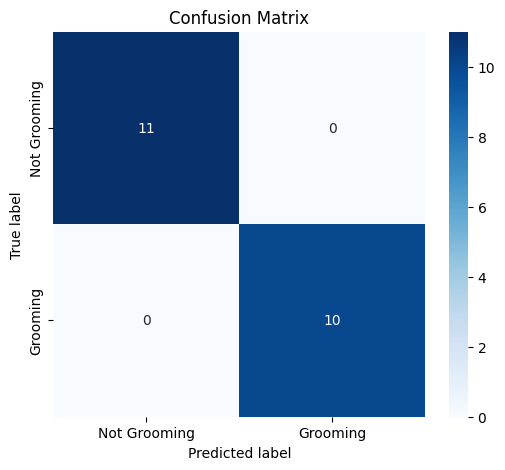


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



In [72]:
model2.fit(X_tfidf_mejorado, y)

y_pred3 = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred3)

fig, axes = plt.subplots(figsize=(6, 5))
# Dibujamos el heatmap de la matriz de confusión
sns.heatmap(
    cm,                    # Matriz de confusión
    annot=True,                # Muestra los números dentro de cada celda
    fmt="d",                   # Formato entero
    cmap="Blues",              # Colormap azul
    xticklabels=['Not Grooming', 'Grooming'],
    yticklabels=['Not Grooming', 'Grooming'],
    ax=axes
)

axes.set_title("Confusion Matrix")
axes.set_xlabel("Predicted label")
axes.set_ylabel("True label")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Revisaremos nuevamente que palabras son mas importantes para determinar por que ocurre el overfitting

In [73]:
model2.fit(X_tfidf_mejorado, y)
importancias = model2.feature_importances_
feature_names = vectorizer.get_feature_names_out()
top_idx = importancias.argsort()[-20:]

for i in top_idx:
    print(f"{feature_names[i]}: {importancias[i]:.4f}")

month: 0.0096
loud: 0.0100
pay: 0.0103
large: 0.0103
stuff: 0.0105
important: 0.0105
new: 0.0108
problem: 0.0114
help: 0.0126
office: 0.0127
sex: 0.0129
picture: 0.0133
cool: 0.0138
profile: 0.0143
morning: 0.0144
cute: 0.0145
want: 0.0146
buy: 0.0169
laughing: 0.0190
great: 0.0293


Ahora vemos que el modelo no esta aprendiendo de palabras "trampas" ni identificadores únicos por lo que pareciera que tf-idf no es el problema ahora